## 2022-02-18: Distribution of $s$-Blade Volumes in $\mathbb{R}^n$

*Last Updated*: 2022-02-20

### Authors
* Kevin Chu (kevin@velexi.com)

### Overview
In this Jupyter notebook, we explore the distribution of the volume of the blade defined by $m$ vectors independently drawn from a uniform distribution over a unit hypersphere in $\mathbb{R}^n$.

### Methodology

* Draw `sample_size` sets of $m$ vectors from a multivariate normal distribution with unit covariance matrix.

    * Using a multivariate normal distribution with diagonal covariance matrix ensures that vectors are drawn uniformly over directions.

    * To obtain a sample on the unit hypersphere, we normalize samples drawn from the multivariate normal distribution to have unit length.
    
* For each sample $x_1, \ldots, x_m$, we perform the following computations to generate the volume distribution.

    * Compute the $\vert x_1 \wedge \cdots \wedge x_m \vert$ by computing determinant of the $R$ matrix of the QR decomposition of the matrix $[x_1 | \cdots | x_m]$.

### User Parameters

* `sample_size`: number of samples to use for estimating probability distributions

In [1]:
# --- User Parameters

# Number of samples to use to estimate probability distributions
sample_size = 10000;

In [2]:
# --- Imports

import Distributions
using Distributions: MvNormal, ContinuousUnivariateDistribution, cdf
using HypothesisTests
using LinearAlgebra
using Plots
using Random
using StatsBase: Histogram, fit

In [3]:
# --- Internal Parameters

# ------ Uniformity test parameters

# p-value cutoff
p_value_cutoff = 0.1;

# maximum number of attempts to generate a sample of vectors
max_attempts = 10;

### Utility Functions

In [4]:
# --- Probability distribution for θ (angle between vector and x_1-axis)

struct ThetaDistribution <: ContinuousUnivariateDistribution
    n::Integer
end

function Distributions.cdf(dist::ThetaDistribution, x::Real)
    # Preparations
    k = dist.n-2

    # Compute pdf
    value = 0
    if k % 2 == 0
        # Precompute re-used coefficients
        sgn = (-1)^(k÷2)
        k_choose_k_over_2 = binomial(big(k), k÷2)
        
        for j = 0:(k÷2 - 1)
            value += (-1)^j * binomial(big(k), j) * sin((k - 2*j) * x) / (k - 2*j)
        end
        value *= 2
        value += sgn * k_choose_k_over_2 * x  # contribution from i = k÷2 term
        value *= sgn / π / k_choose_k_over_2

    else
        norm_ = 0
        for j = 0:(k-1)÷2
            coef = (-1)^j * binomial(big(k), j) / (k - 2*j)
            value += coef * (1 - cos((k - 2*j) * x))
            norm_ += coef
        end
        value /= 2 * norm_

    end

    return value
end

# --- Tests

# 2D: cdf(x) = x / π
theta_dist_2d = ThetaDistribution(2)
for x = range(0, π; length=10)
    computed_cdf = cdf(theta_dist_2d, x)
    expected_cdf = x / π
    @assert (computed_cdf ≈ expected_cdf) "Expected: $(expected_cdf). Got: $(computed_cdf)"
end

# 3D: cdf(x) = 0.5 * (1 - cos(x))
theta_dist_3d = ThetaDistribution(3)
for x = range(0, π; length=10)
    computed_cdf = cdf(theta_dist_3d, x)
    expected_cdf = 0.5 * (1 - cos(x))
    @assert (computed_cdf ≈ expected_cdf) "Expected: $(expected_cdf). Got: $(computed_cdf)"
end

In [5]:
function generate_blades(n::Integer, s::Integer, sample_size::Integer)::Tuple
    """
    Generate a sample of s-dimensional blades in an n-dimensional space where each blade
    is defined by unit vectors drawn from a uniform distribution over the surface of an
    unit n-sphere.

    Parameters
    ----------
    n: dimension of space

    s: grade of blades

    sample_size: number of blades to include in sample
    
    Return values
    -------------
    vectors: sample of vectors
    
    uniformity_stats: results of tests for uniformity of sample on unit n-sphere
    """
    # --- Set up uniformity tests

    theta_dist = ThetaDistribution(n)
    AD_p_value = 0
    KS_p_value = 0

    # --- Generate sample of vectors

    num_attempts = 0
    vectors = undef
    while ( ((AD_p_value < p_value_cutoff) || (KS_p_value < p_value_cutoff)) &&
            (num_attempts < max_attempts) )

        # Generate new sample
        dist = MvNormal(zeros(n), ones(n))
        num_vectors = sample_size * s
        vectors = rand(dist, num_vectors)
        for i = 1:num_vectors
            vectors[:, i] /= norm(vectors[:, i])
        end

        # Perform test for uniformity on unit n-sphere
        thetas = map(i -> atan(norm(vectors[:, i][2:end]), vectors[:, i][1]), 1:num_vectors)

        # Anderson-Darling Test
        AD_p_value = pvalue(OneSampleADTest(thetas, theta_dist))

        # Kolmogorov-Smirnov Test
        KS_p_value = pvalue(ExactOneSampleKSTest(thetas, theta_dist))

        # Update attempt count
        num_attempts += 1
    end

    # --- Group vectors into blades

    blades = []
    for i = 1:sample_size
        push!(blades, vectors[:, (i-1)*s+1:i*s])
    end

    # --- Save uniformity test results

    uniformity_stats = (
        success=(num_attempts < max_attempts),
        num_attempts=num_attempts,
        AD_p_value=AD_p_value,
        KS_p_value=KS_p_value,
    )
    
    return blades, uniformity_stats
end

generate_blades (generic function with 1 method)

### Distributions in 2D

In [6]:
# --- Generate blades

# Parameters
n_2d = 2;  # dimension of space
s = 2;  # grade of blades

# Generate sample of blades
blades, uniformity_stats = generate_blades(n_2d, s, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit circle.")
    display(uniformity_stats)
end

# Compute blade volumes
signed_volumes = Vector{Float64}()
for i = 1:sample_size
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

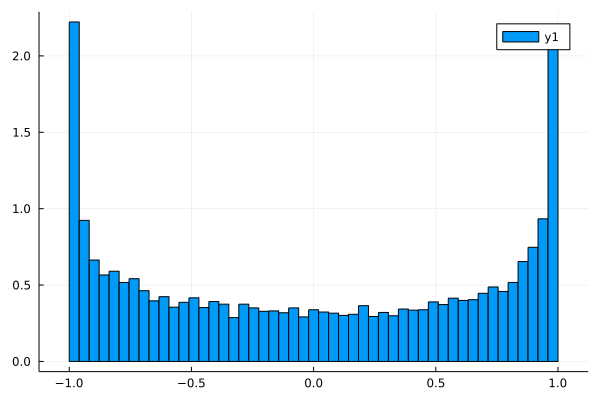

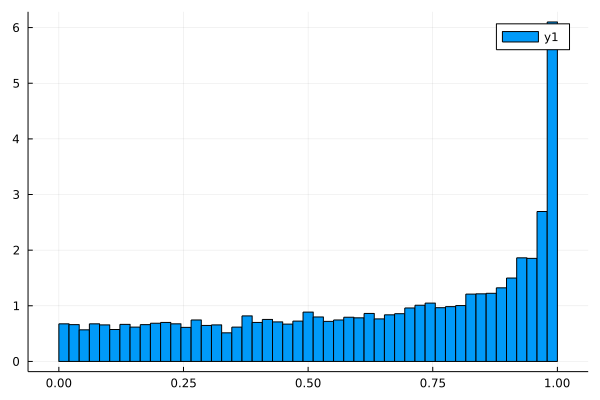

In [7]:
# --- Generate blade volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))

display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

### Distributions in 3D

In [8]:
# --- Generate blades

# Parameters
n_3d = 3;  # dimension of space
s = 2;  # grade of blades

# Generate sample of blades
blades, uniformity_stats = generate_blades(n_3d, s, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit sphere.")
    display(uniformity_stats)
end

# Compute blade volumes
signed_volumes = Vector{Float64}()
for i = 1:sample_size
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

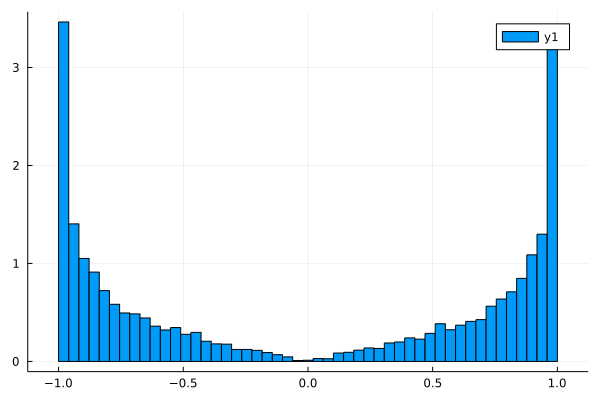

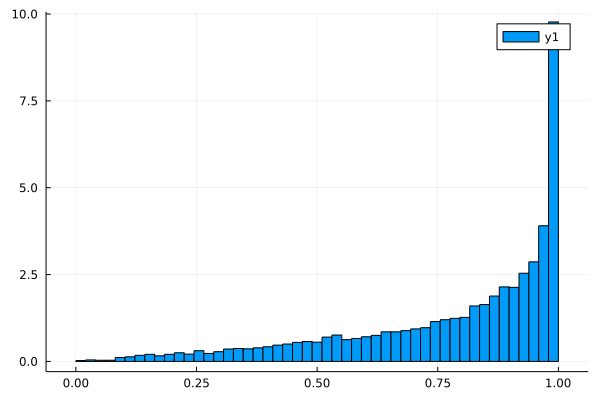

In [9]:
# --- Generate blade volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))

display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);

### Distributions in Arbitrary Dimensions

In [10]:
# --- Generate blades

# Parameters
n = 100;  # dimension of space
s = 10;  # grade of blades

# Generate sample of vectors
blades, uniformity_stats = generate_blades(n, s, sample_size)
if !uniformity_stats[:success]
    println("FAILED to generated sample with sufficient uniformity on unit $(n)-sphere.")
    display(uniformity_stats)
end

# Compute blade volumes
signed_volumes = Vector{Float64}()
for i = 1:sample_size
    F = qr(blades[i])
    signed_volume = det(F.R)
    push!(signed_volumes, signed_volume)
end

volumes = abs.(signed_volumes);

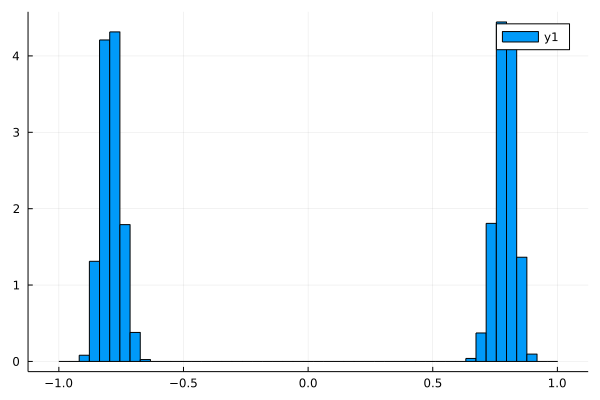

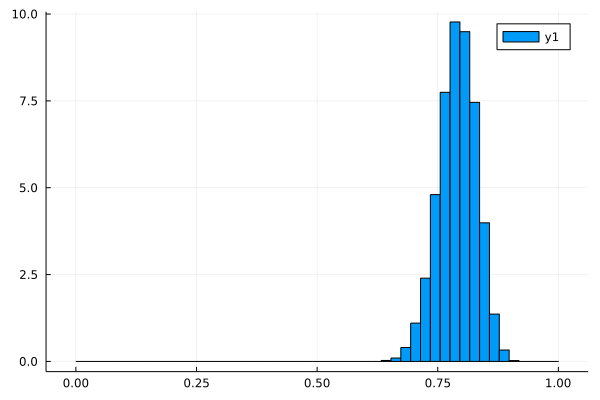

In [11]:
# --- Generate volume distributions

# Histogram parameters
num_hist_bins = 50

# Plot histograms
hist_bins_signed = range(-1, 1; length=num_hist_bins)
plt_signed = plot(histogram(signed_volumes; bins=hist_bins_signed, normalize=true))

hist_bins = range(0, 1; length=num_hist_bins)
plt = plot(histogram(volumes; bins=hist_bins, normalize=true))
display(plt_signed)
display(plt)

# Compute empirical volume distributions
hist_signed = fit(Histogram, signed_volumes; nbins=num_hist_bins)
edf_signed = normalize(hist_signed; mode=:pdf);

hist = fit(Histogram, volumes; nbins=num_hist_bins)
edf = normalize(hist; mode=:pdf);